Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model InceptionResNetV2, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

In [3]:
# Import

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


2023-08-31 09:55:11.574804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 09:55:11.603312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 09:55:20.921127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
# Set up TODO update to UoA-DR

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test') 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "Image Number"
y_name = "Class"

labels.head()



# possible_labels = labels['Class'].unique()
# print(possible_labels)

,Image Number,Class,Healthy,NPDR,PDR
0,1,NPDR,0,1,0
1,2,NPDR,0,1,0
2,3,NPDR,0,1,0
3,4,NPDR,0,1,0
4,5,NPDR,0,1,0


In [20]:
# Custom functions 

def to_jpg(id):
    return str(id) + ".jpg"

# Convert the 'id' column to string type
labels[x_name] = labels[x_name].astype(str)
# Apply the to_jpg function
labels[x_name] = labels[x_name].apply(to_jpg)

labels.head()

,Image Number,Class,Healthy,NPDR,PDR
0,1.jpg,NPDR,0,1,0
1,2.jpg,NPDR,0,1,0
2,3.jpg,NPDR,0,1,0
3,4.jpg,NPDR,0,1,0
4,5.jpg,NPDR,0,1,0


In [21]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 32
has_shuffle = True
seed = 42

gen = ImageDataGenerator(
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = (331,331), # image height , image width
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size



Found 130 validated image filenames belonging to 3 classes.
Found 32 validated image filenames belonging to 3 classes.


(32, 331, 331, 3)

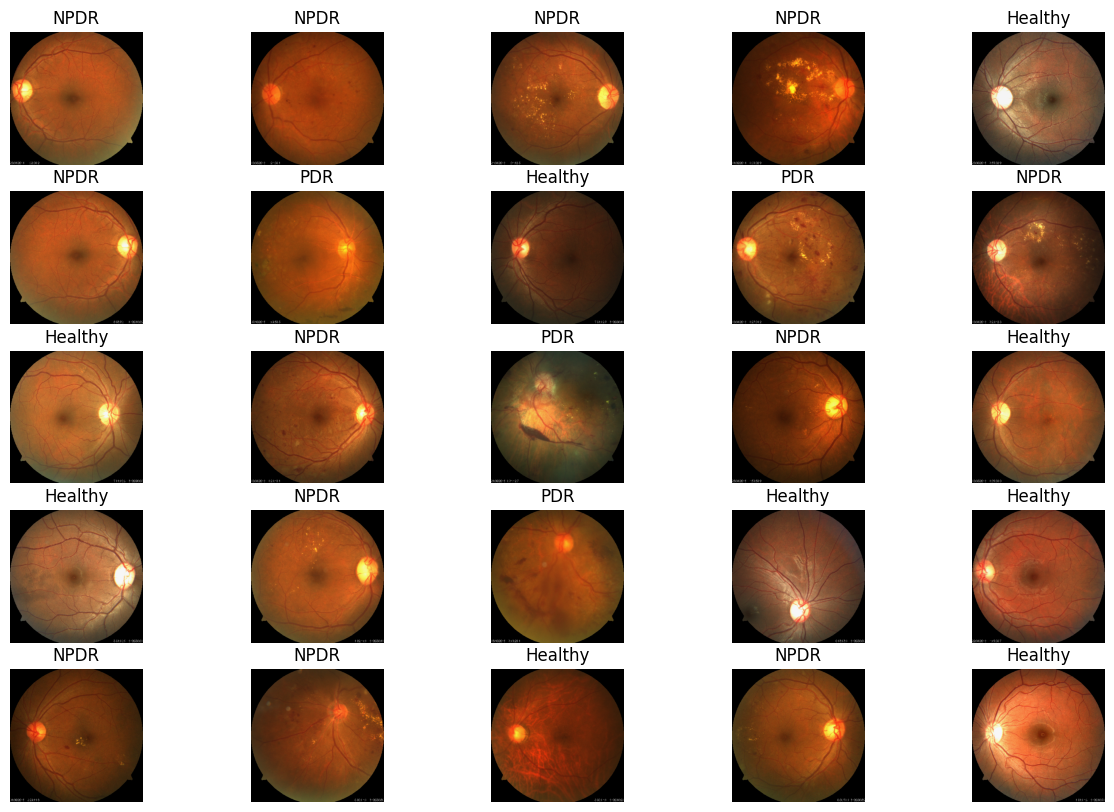

In [30]:
# Plot images

a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list


def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(25):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')

plot_images(x,y)


# def plot_images_with_numbers(img, labels, image_numbers):
#     plt.figure(figsize=[15, 10])
#     for i in range(25):
#         plt.subplot(5, 5, i+1)
#         plt.imshow(img[i])
#         plt.title(f"{image_numbers[i]} - {class_names[np.argmax(labels[i])]}")
#         plt.axis('off')

# # Assuming you have a DataFrame named 'labels' with the 'Image Number' column
# image_numbers = labels[x_name]

# plot_images_with_numbers(x, y, image_numbers)

In [31]:
# Build model

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(3, activation='softmax')
	])


In [32]:
# Compile model

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (

In [33]:
# Defining callbacks to preserve the best results

early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back


In [34]:
# Train model

batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=25,
					callbacks=[early])


Epoch 1/25


2023-08-31 10:46:16.972431: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2f819200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-31 10:46:16.972448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-08-31 10:46:16.976129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-31 10:46:17.138786: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 17s 4s/step - loss: 1.4077 - accuracy: 0.3265 - val_loss: 0.4307 - val_accuracy: 1.0000
Epoch 2/25
4/4 [==============================] - 4s 928ms/step - loss: 1.0246 - accuracy: 0.4898 - val_loss: 1.2425 - val_accuracy: 0.0938
Epoch 3/25
4/4 [==============================] - 4s 897ms/step - loss: 0.9402 - accuracy: 0.5408 - val_loss: 0.5351 - val_accuracy: 0.8750
Epoch 4/25
4/4 [==============================] - 4s 912ms/step - loss: 0.8799 - accuracy: 0.6224 - val_loss: 0.4699 - val_accuracy: 1.0000
Epoch 5/25
4/4 [==============================] - 4s 1s/step - loss: 0.8214 - accuracy: 0.6484 - val_loss: 0.5037 - val_accuracy: 0.8750
Epoch 6/25
4/4 [==============================] - 4s 1s/step - loss: 0.9198 - accuracy: 0.6020 - val_loss: 0.1370 - val_accuracy: 1.0000
Epoch 7/25
4/4 [==============================] - 4s 1s/step - loss: 0.8196 - accuracy: 0.6719 - val_loss: 0.6003 - val_accuracy: 0.7812
Epoch 8/25
4/4 [==========================

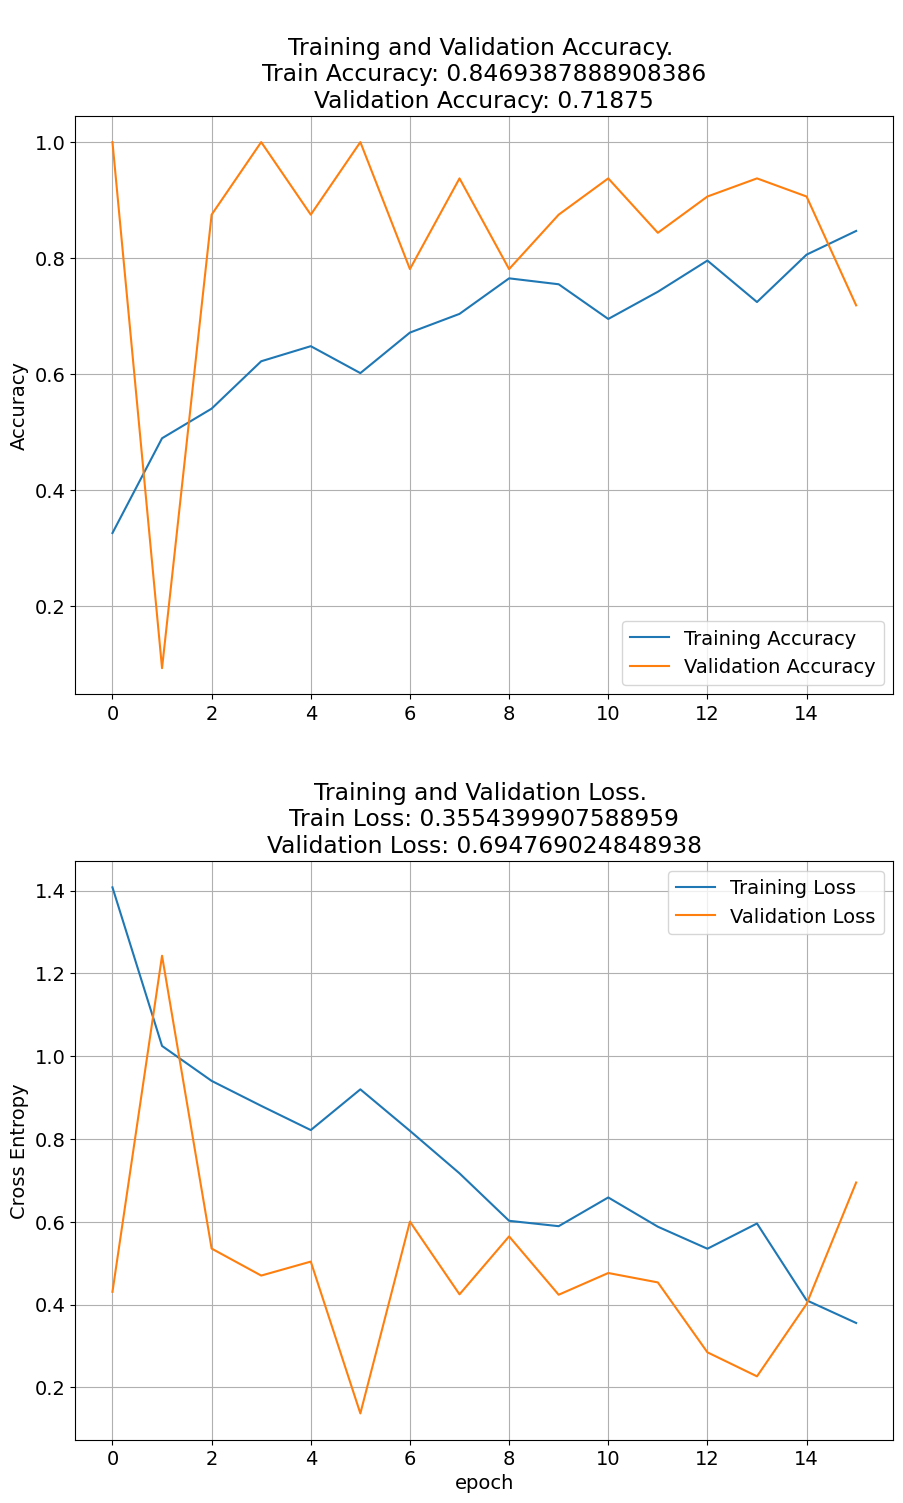

In [35]:
# Visualize model

# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [36]:
# Evaluate model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


1/1 [==============================] - 1s 1s/step - loss: 0.1236 - accuracy: 1.0000
[0.12359675019979477, 1.0]
Accuracy: 100.0000%
Loss:  0.12359675019979477


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [38]:
print(possible_labels)

['NPDR' 'PDR' 'Healthy']


1/1 [==============================] - 0s 17ms/step
[[0.0706934 0.8124082 0.1168984]]
Predicted class: PDR


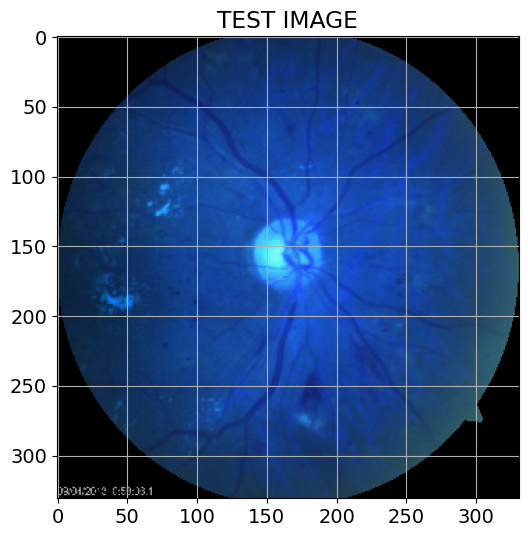

In [41]:
test_img_path = "1.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print(prediction)

# # Assuming your class labels are stored in a list called 'class_labels'
# class_labels = ["class1", "class2", "class3", ...]

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

# # Get the predicted class label using the index
# predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", possible_labels[predicted_class_index])



In [42]:
# Save model

model.save("Model.h5")
